In [1]:
DATAPATH = '../data/'
XFERPATH = '~/gdrive/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906161241.csv'
VALID_FNAME = 'embed_valid_201906161241.csv'
TEST_FNAME = 'embed_test_201906161241.csv'
MODEL_TYPE_ID = 'lrp'

do_copy_files = False

In [2]:
if do_copy_files:
    train_from = XFERPATH + TRAIN_FNAME
    valid_from = XFERPATH + VALID_FNAME
    test_from = XFERPATH + TEST_FNAME
    !cp $train_from $DATAPATH
    !cp $valid_from $DATAPATH
    !cp $test_from $DATAPATH

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
timestamp = datetime.now().strftime('%Y%m%d%H%M')
timestamp

'201907101727'

In [5]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,-9031,78190,28476,15732,-3761,22135
815783987784187904,2019-05-24 15:36:01+00:00,False,-1787,-57509,29939,-32859,-20955,13103
3458239641,2019-05-24 19:00:37+00:00,False,-42708,-31384,17130,60833,11307,35467
1003729876250226688,2019-05-26 12:53:00+00:00,True,-5514,61646,16234,105381,-7119,-35271
2360143940,2019-05-28 03:50:46+00:00,False,6762,-16422,-36991,29061,37017,-27550


In [6]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34146, 513) (10914, 513) (10450, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [7]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train)
X_valid, y_valid = getxy(df_valid)
X_test, y_test = getxy(df_test)

In [8]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.07448615 0.04572162 0.03133295 0.02649418 0.02486901 0.02336328
 0.0212634  0.01973232 0.0190449  0.01741141 0.01669182 0.01556902
 0.01513328 0.01464926 0.01418335 0.01328785 0.01316902 0.0125086
 0.01213418 0.01157767 0.01139247 0.01087464 0.01081028 0.01053631
 0.01014631 0.00983309 0.00958958 0.00949487 0.00899379 0.00876955
 0.008622   0.00836985 0.00815295 0.0080947  0.00797596 0.00769387
 0.00759998 0.00751639 0.00737197 0.00728209 0.00714329 0.0070864
 0.00684909 0.00680966 0.00644459 0.006363   0.00630406 0.00621991
 0.00609532 0.00601934 0.00585377 0.00580863 0.00570756 0.00564411
 0.00559982 0.0055034  0.00544857 0.00528301 0.00520956 0.00510563
 0.00508884 0.00499674 0.00492754 0.00484815]


In [9]:
model = Pipeline([('pca',  PCA(50)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.08))])
model = model.fit(X_train, y_train)

/home/andy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
def save_predictions(df, predictions, which_set):
    pred_df = df[['male']].copy()
    pred_df['pred'] = predictions
    path = DATAPATH + MODEL_TYPE_ID + '_' + which_set + '_pred_' + timestamp + '.csv'
    pred_df.to_csv(path)    

In [11]:
y_train_pred = model.predict_proba(X_train)[:,1]
save_predictions(df_train, y_train_pred, 'train')
f1_score(y_train, y_train_pred>.5)

0.7048388513216826

In [12]:
y_pred = model.predict_proba(X_valid)[:,1]
save_predictions(df_valid, y_pred, 'valid')
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3304 2153]
 [1912 3545]]


0.6355894217839535

In [13]:
accuracy_score(y_valid, y_pred>.5)

0.6275426058273776

In [14]:
y_test_pred = model.predict_proba(X_test)[:,1]
save_predictions(df_test, y_test_pred, 'test')
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[3135 2090]
 [1877 3348]]


0.6279658632654975

In [15]:
accuracy_score(y_test, y_test_pred>.5)

0.6203827751196173

Test set ROC AUC: 0.6749124791099104


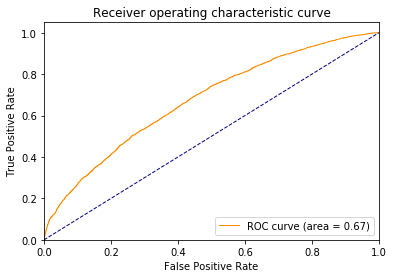

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))
plt.show()

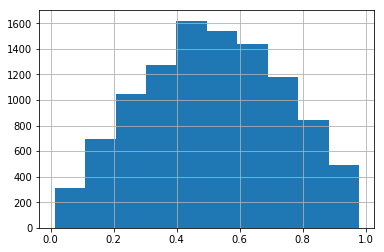

In [17]:
pd.Series(y_test_pred).hist()
plt.show()

In [18]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (y_test_pred>=pbot)&(y_test_pred<ptop)
    count = int(mask.sum())
    acc = accuracy_score(y_test[mask], y_test_pred[mask]>.5)
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 'accuracy':[acc]})
    df_acc = pd.concat([df_acc, row])
df_acc.set_index(['minprob','maxprob'])

,,count,accuracy
minprob,maxprob,,
0.0,0.1,263,0.844106
0.1,0.2,693,0.754690
0.2,0.3,1082,0.677449
0.3,0.4,1307,0.599082
0.4,0.5,1667,0.524295
0.5,0.6,1605,0.514019
0.6,0.7,1459,0.579849
0.7,0.8,1202,0.636439
0.8,0.9,819,0.736264


In [19]:
from joblib import dump
model_path = DATAPATH + MODEL_TYPE_ID + '_model_' + timestamp + '.joblib'
dump(model, model_path)

['../data/lrp_model_201907101727.joblib']